# Distance from male X haplotypes to archaic pseudohaploids

In [38]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

from HorizonPlot import horizon_plot

numpy.random.seed(7)

Plotting setup:

In [39]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

Ignore deprecation warnings from mainly seaborn:

In [40]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [41]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [42]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Load meta data

In [43]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

pop_categories = pandas.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Read in distances to archaics

In [44]:
male_dist_to_archaic = pandas.read_hdf(str(ag.steps_dir / 'archaic_dist_stores/archaic_dist_data_chrX_100kb.store'))


Distribution of uncalled bases:

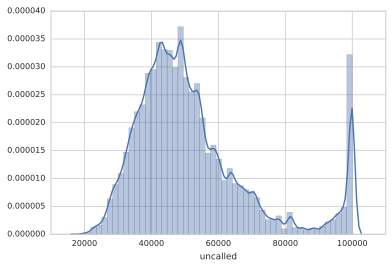

In [45]:
sns.distplot(male_dist_to_archaic.uncalled) ;

In [46]:
male_dist_to_archaic.head()

,chrom,start,end,pop_label,indiv_1,pseud_1,indiv_2,pseud_2,dist,mismatch,match,uncalled,region_label_1,region_id_1,region_1
142600,X,0,100000,NA,B_Dinka-3,A,Altai,A,0.000000,0,281,99719,Africa,0,Africa
480500,X,0,100000,NA,B_Dinka-3,A,Denisova,B,0.006897,2,288,99710,Africa,0,Africa
491350,X,0,100000,NA,B_Dinka-3,A,Denisova,A,0.003448,1,289,99710,Africa,0,Africa
558000,X,0,100000,NA,B_Dinka-3,A,Altai,B,0.000000,0,281,99719,Africa,0,Africa
142601,X,100000,200000,NA,B_Dinka-3,A,Altai,A,0.003916,12,3052,96936,Africa,0,Africa


In [47]:
df = (male_dist_to_archaic
      .loc[male_dist_to_archaic.uncalled < 70000]
      .groupby(['indiv_1', 'indiv_2', 'start'])['dist']
      .mean()
      .reset_index()
     )
      
      

In [48]:
df.head()

,indiv_1,indiv_2,start,dist
0,B_Australian-4,Altai,2900000,0.001545
1,B_Australian-4,Altai,3000000,0.001190
2,B_Australian-4,Altai,3100000,0.002224
3,B_Australian-4,Altai,3900000,0.001604
4,B_Australian-4,Altai,4000000,0.001355


In [49]:
df.groupby('indiv_2').describe()

dist                                                    \
             count      mean       std       min       25%       50%   
indiv_2                                                                
Altai     218266.0  0.001016  0.000410  0.000009  0.000731  0.000947   
Denisova  217835.0  0.001068  0.000419  0.000182  0.000764  0.001006   

                                 start                                         \
               75%       max     count          mean           std        min   
indiv_2                                                                         
Altai     0.001229  0.003963  218266.0  7.904270e+07  4.509440e+07  1700000.0   
Denisova  0.001284  0.004040  217835.0  7.899853e+07  4.509966e+07  1700000.0   

                                                            
                 25%         50%          75%          max  
indiv_2                                                     
Altai     37500000.0  80900000.0  118900000.0  154900000.0  
Denisova  37400000.0  80900000.0  118800000.0  154900000.0

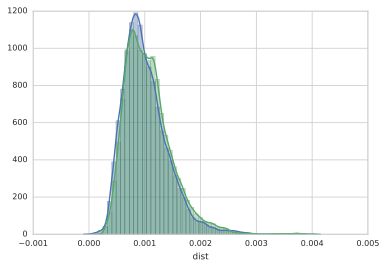

In [50]:
g = sns.distplot(df.loc[df.indiv_2 == 'Altai'].dist.dropna())
g = sns.distplot(df.loc[df.indiv_2 == 'Denisova'].dist.dropna())
plt.show()

In [51]:
df.loc[df.indiv_2 == 'Altai'].assign(chrom='X').head()

,indiv_1,indiv_2,start,dist,chrom
0,B_Australian-4,Altai,2900000,0.001545,X
1,B_Australian-4,Altai,3000000,0.001190,X
2,B_Australian-4,Altai,3100000,0.002224,X
3,B_Australian-4,Altai,3900000,0.001604,X
4,B_Australian-4,Altai,4000000,0.001355,X


In [53]:
plt.close()
fig = horizon_plot(df.loc[df.indiv_2 == 'Denisova'].assign(chrom='X'), 'dist',
             width=100000, row='indiv_1', col='chrom', size=0.3, aspect=30)


In [ ]:
plt.close()
fig = horizon_plot(df.loc[df.indiv_2 == 'Altai'].assign(chrom='X'), 'dist',
             width=100000, row='indiv_1', col='chrom', size=0.3, aspect=30)


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.bar(df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_English-1')].start,
        df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_English-1')].dist, width=100000)
ax2.bar(df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_English-1')].start,
        df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_English-1')].dist, width=100000)
#plt.ylim(0, 0.0005)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.bar(df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_Papuan-8')].start,
        df.loc[(df.indiv_2 == 'Altai') & (df.indiv_1 == 'S_Papuan-8')].dist, width=100000)
ax2.bar(df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_Papuan-8')].start,
        df.loc[(df.indiv_2 == 'Denisova') & (df.indiv_1 == 'S_Papuan-8')].dist, width=100000)
#plt.ylim(0, 0.0005)

In [ ]:
import pandas as pd
import numpy as np
n = 1500
pops = 140

df = pd.DataFrame({'chrom': ['chr1']*pops*n,
                   'pop': [x for y in ([chr(65+i)]*n for i in range(pops)) for x in y],
                   'start': list(range(1*n)) * pops, 
#                    'pi': np.add(list(np.sin(np.linspace(-np.pi, 10*np.pi, 1*n))) * pops, 5*np.random.random(n*pops))-2 })
                   'pi': np.add(list(np.sin(np.linspace(-np.pi, 10*np.pi, 1*n))) * pops, np.random.normal(size=n*pops)) })

fig = horizon_plot(df, 'pi', width=1, col='chrom', row='pop', size=0.3, aspect=30)

